# Libraries

In [2]:
from numpy import mean, std
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
import os

## Load data and resample

In [3]:
# load the dataset
def load_dataset(file_path):
    # load the dataset as a dataframe
    data_df = pd.read_pickle(file_path)
    # correct data types
    fix_cols = data_df.columns[data_df.dtypes == 'object']
    data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')
    # remove redundant features
    data_df.drop(['total_review_count', 'halal_review_count', 'halal_negation_count', 'halal_truck_count'], inplace=True, axis=1)
    # split into features and target
    X, y = data_df.drop('halal', axis=1), data_df.halal
    return X, y

# define resampling method
def split_and_resample(X, y, test_size=0, resampling=None):
    if test_size > 0:
        # setting up testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
        x_train, x_test, y_train, y_test = X, pd.DataFrame(columns=X.columns, dtype=X.dtypes.values),\
                                            y, pd.Series(name=y.name, dtype=y.dtypes)
    # concatenate our training data back together
    X = pd.concat([x_train, y_train], axis=1)
    # separate minority and majority classes
    min_class = X[X.halal==X.halal.value_counts().sort_values().index[0]]
    max_class = X[X.halal==X.halal.value_counts().sort_values().index[1]]
    if not resampling:
        return x_train, y_train, x_test, y_test
    # oversampling minority
    if resampling == 'oversample':
        new_min_class = resample(min_class, replace=True, n_samples=(len(max_class)))
        upsampled = pd.concat([max_class, new_min_class])
        return upsampled.drop('halal', axis=1), upsampled.halal, x_test, y_test
    elif resampling == 'undersample':
        new_max_class = resample(max_class, replace=True, n_samples=(len(min_class)))
        downsampled = pd.concat([new_max_class, min_class])
        return downsampled.drop('halal', axis=1), downsampled.halal, x_test, y_test
    elif resampling == 'SMOTE':
        x_train, y_train = SMOTE().fit_sample(x_train, y_train)
        return x_train, y_train, x_test, y_test

# define models to test
def get_models():
    models = list()
    # BASE
    models.append(DummyClassifier(strategy='constant', constant=1))
    # CART
    models.append(DecisionTreeClassifier(max_depth=15)) # max depth set to 15 to avoid overfitting
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    # RF
    models.append(RandomForestClassifier(n_estimators=10, max_depth=15))
    # XGBoost
    models.append(XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=15))
    return models

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
   # calculate precision-recall curve
   p, r, _ = precision_recall_curve(y_true, probas_pred)
   # calculate area under curve
   return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, error_score='raise')
    return scores

## Compare models performance after modifying halal_truck to include 'halal cart(s)'

In [37]:
# define the location of the dataset
file_path_v1 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
file_path_v2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v2.pkl'

def run_model_comparison(file_path):
    # load the dataset
    X, y = load_dataset(file_path)
    # encode boolean data as integers
    y = y*1
    X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
    # split to train and test
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
    # define models
    models = get_models()
    # evaluate each model
    print('From: ', file_path.split('/')[-1].split('.')[0])
    results = []
    for i, model in enumerate(models):
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, model)
        results.append(scores)
        # summarize performance
        print('>%s %.3f (%.3f)' % (model.__class__.__name__, mean(scores), std(scores)))
    print('\n')
    return results

res_list = []
for file_path in [file_path_v1, file_path_v2]:
    res_list.extend(run_model_comparison(file_path=file_path))

From:  restaurant_cat_and_num
>DummyClassifier 0.750 (0.003)
>DecisionTreeClassifier 0.922 (0.021)
>Pipeline 0.886 (0.028)
>RandomForestClassifier 0.938 (0.024)
>XGBClassifier 0.945 (0.018)


From:  restaurant_cat_and_num_v2
>DummyClassifier 0.750 (0.001)
>DecisionTreeClassifier 0.938 (0.023)
>Pipeline 0.918 (0.023)
>RandomForestClassifier 0.956 (0.020)
>XGBClassifier 0.956 (0.022)




## Comapre resampling methods with new dataset

In [47]:
# define the location of the dataset
file_path_v2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v2.pkl'
# load the dataset
X, y = load_dataset(file_path_v2)
# encode boolean data as integers
y = y*1
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
# define models and resampling methods
models = get_models()
resampling = [None, 'oversample', 'undersample', 'SMOTE']
# evaluate each model
results = []
for resample_method in resampling:
    # split and oversample
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling=resample_method)
    print('>>%s: ' % str(resample_method).upper())
    for model in models:
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, model)
        results.append(scores)
        # summarize performance
        print('>%s %.3f (%.3f)' % (model.__class__.__name__, scores.mean(), scores.std()))
        # evaluate against test set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(' >accuracy: %.3f'  % accuracy_score(y_test, y_pred))
        print(' >recall: %.3f' % recall_score(y_test, y_pred))
    print()

>>NONE: 
>DummyClassifier 0.860 (0.003)
 >accuracy: 0.774
 >recall: 1.000
>DecisionTreeClassifier 0.887 (0.033)
 >accuracy: 0.744
 >recall: 0.769
>Pipeline 0.908 (0.019)
 >accuracy: 0.839
 >recall: 0.900
>RandomForestClassifier 0.901 (0.032)
 >accuracy: 0.833
 >recall: 0.869
>XGBClassifier 0.913 (0.032)
 >accuracy: 0.827
 >recall: 0.892

>>OVERSAMPLE: 
>DummyClassifier 0.750 (0.002)
 >accuracy: 0.750
 >recall: 1.000
>DecisionTreeClassifier 0.927 (0.024)
 >accuracy: 0.750
 >recall: 0.841
>Pipeline 0.911 (0.029)
 >accuracy: 0.732
 >recall: 0.746
>RandomForestClassifier 0.953 (0.017)
 >accuracy: 0.786
 >recall: 0.849
>XGBClassifier 0.959 (0.018)
 >accuracy: 0.810
 >recall: 0.889

>>UNDERSAMPLE: 
>DummyClassifier 0.750 (0.007)
 >accuracy: 0.762
 >recall: 1.000
>DecisionTreeClassifier 0.808 (0.057)
 >accuracy: 0.696
 >recall: 0.719
>Pipeline 0.835 (0.057)
 >accuracy: 0.720
 >recall: 0.742
>RandomForestClassifier 0.835 (0.073)
 >accuracy: 0.714
 >recall: 0.734
>XGBClassifier 0.847 (0.090)
 >

### Evaluate against test set

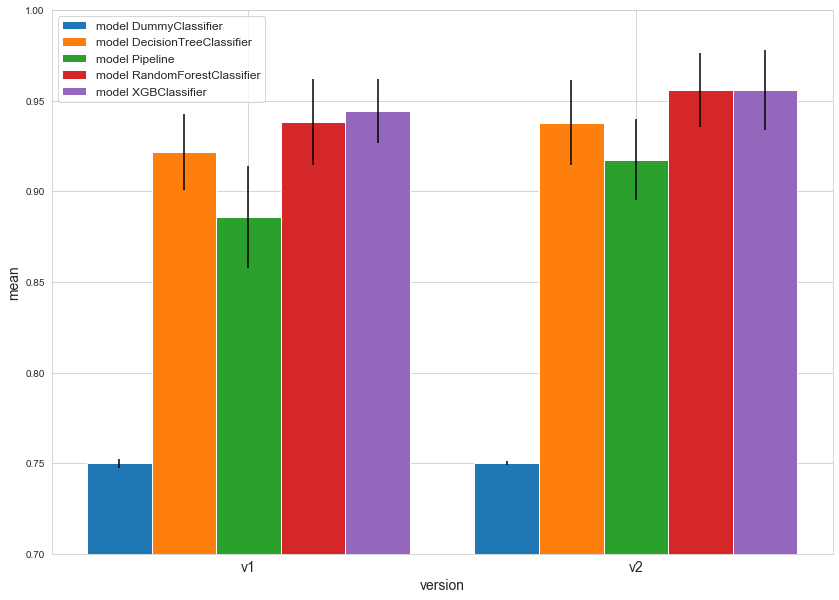

In [38]:
# plot the results
plot_df = pd.DataFrame(columns=['version', 'model', 'results', 'mean', 'sd'])
plot_df['version'] = ['v1'] * 5 + ['v2'] * 5
models=get_models()
plot_df['model'] = [model.__class__.__name__ for model in models] * 2
plot_df['results'] = [result for result in res_list]
plot_df['mean'] = plot_df['results'].apply(mean)
plot_df['sd'] = plot_df['results'].apply(std)

def grouped_barplot(df, cat,subcat, val , err):
    u = df[cat].unique()
    x = np.arange(len(u))
    subx = df[subcat].unique()
    offsets = (np.arange(len(subx))-np.arange(len(subx)).mean())/(len(subx)+1.)
    width= np.diff(offsets).mean()
    sns.set_style('whitegrid')
    plt.figure(figsize=(14,10))
    for i,gr in enumerate(subx):
        dfg = df[df[subcat] == gr]
        plt.bar(x+offsets[i], dfg[val].values, width=width, 
                label="{} {}".format(subcat, gr), yerr=dfg[err].values)
    plt.xlabel(cat, size=14)
    plt.ylabel(val, size=14)
    plt.xticks(x, u, size=14)
    plt.ylim(0.7,1)
    plt.legend(loc='upper left', fontsize=12)
    plt.show()

cat = 'version'
subcat = 'model'
val = 'mean'
err = 'sd'
grouped_barplot(plot_df, cat, subcat, val, err )

## Model metrics for Random Forest with oversampling to compare to Baseline-3

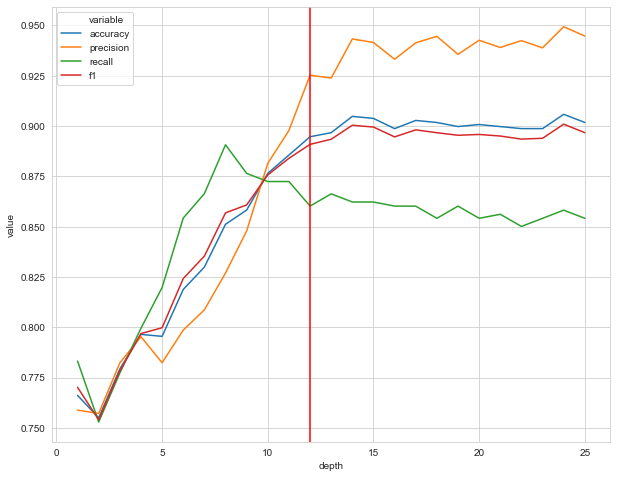

In [48]:
# define the location of the dataset
file_path_v2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v2.pkl'
# load the dataset
X, y = load_dataset(file_path_v2)
# encode boolean data as integers
y = y*1
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
# split to train and test
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
# initialize RF with different depths
depths = range(1, 26)
plot_df = pd.DataFrame(columns=['depth', 'accuracy', 'precision', 'recall', 'f1'], dtype=float)
plot_df['depth'] = depths
scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'}

for i, depth in plot_df['depth'].iteritems(): 
    model = RandomForestClassifier(max_depth=depth)
    # train model and collect metrics
    cv_scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = 5, n_jobs = -1)
    plot_df.loc[i, 'accuracy'] = cv_scores['test_acc'].mean()
    plot_df.loc[i, 'precision'] = cv_scores['test_prec'].mean()
    plot_df.loc[i, 'recall'] = cv_scores['test_rec'].mean()
    plot_df.loc[i, 'f1'] = cv_scores['test_f1'].mean()
    
# visualize decision tree metrics vs max_depth
plt.figure(figsize=(10,8))
sns.lineplot(x='depth', y='value', hue='variable', data=pd.melt(plot_df, ['depth']))
plt.axvline(x=12, color='red')
plt.show()

ROC-AUC:   0.673
Accuracy:  0.768
Precision: 0.793
Recall:    0.907
f1:        0.846
Classification report: 
               precision    recall  f1-score   support

           0       0.67      0.44      0.53        50
           1       0.79      0.91      0.85       118

    accuracy                           0.77       168
   macro avg       0.73      0.67      0.69       168
weighted avg       0.76      0.77      0.75       168

Confusion matrix: 
 [[ 22  28]
 [ 11 107]]


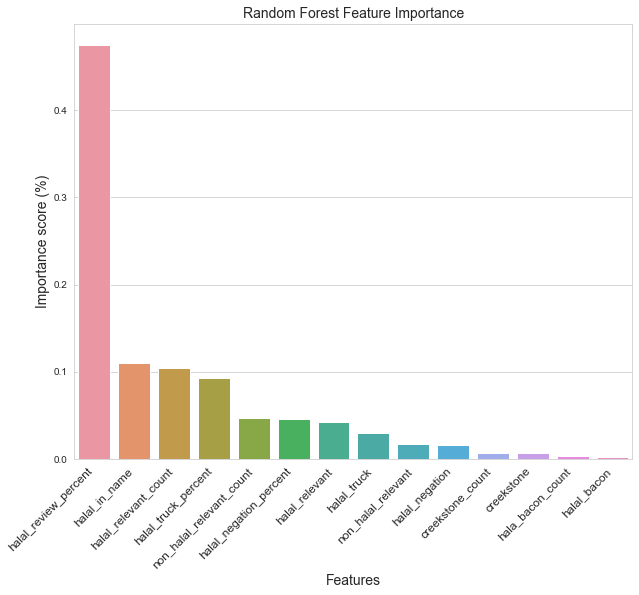

In [54]:
# use max depth of 12
model = RandomForestClassifier(max_depth=12)
model.fit(X_train, y_train)

# model performance on test set
y_pred = model.predict(X_test)
print('ROC-AUC:   %.3f' % roc_auc_score(y_test, y_pred))
print('Accuracy:  %.3f'  % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall:    %.3f' % recall_score(y_test, y_pred))
print('f1:        %.3f' % f1_score(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))


# Feature importance from RF
plot_df = pd.DataFrame(data={'importances': model.feature_importances_, 'features': X.columns})

# plot
plt.figure(figsize=(10,8))
g = sns.barplot(x=plot_df['features'], y=plot_df['importances'],
                order=plot_df.sort_values('importances', ascending=False).features)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Random Forest Feature Importance', size=14)
g.set_ylabel('Importance score (%)', size=14)
g.set_xlabel('Features', size=14)
g.set_xticklabels(g.get_xticklabels(), size=12)
plt.show()

# Noramlize numeric values?

## Try XGBoost with oversampling

In [14]:
# define the location of the dataset
file_path_v2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v2.pkl'
# load the dataset
X, y = load_dataset(file_path_v2)
# encode boolean data as integers
y = y*1
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
# split to train and test
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
# define model 
model = XGBClassifier(max_depth=12,
                        subsample=0.8,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.001)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15, eval_metric='aucpr', eval_set=eval_set)
# evaluate against test set
y_pred = model.predict(X_test)
print('Accuracy:  %.3f'  % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall:    %.3f' % recall_score(y_test, y_pred))
print('f1:        %.3f' % f1_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))

[0]	validation_0-aucpr:0.93655	validation_1-aucpr:0.93912
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 15 rounds.
[1]	validation_0-aucpr:0.95718	validation_1-aucpr:0.94803
[2]	validation_0-aucpr:0.96559	validation_1-aucpr:0.94957
[3]	validation_0-aucpr:0.96588	validation_1-aucpr:0.94834
[4]	validation_0-aucpr:0.96530	validation_1-aucpr:0.94628
[5]	validation_0-aucpr:0.96644	validation_1-aucpr:0.94743
[6]	validation_0-aucpr:0.96641	validation_1-aucpr:0.94687
[7]	validation_0-aucpr:0.96505	validation_1-aucpr:0.94822
[8]	validation_0-aucpr:0.96526	validation_1-aucpr:0.95203
[9]	validation_0-aucpr:0.96628	validation_1-aucpr:0.95205
[10]	validation_0-aucpr:0.96676	validation_1-aucpr:0.95040
[11]	validation_0-aucpr:0.96658	validation_1-aucpr:0.95014
[12]	validation_0-aucpr:0.96705	validation_1-aucpr:0.94975
[13]	validation_0-aucpr:0.96686	validation_1-aucpr:0.94922
[14]	validation_0-aucpr

### Pickle and save False Positives for more feature engineering

In [23]:
# get indices of FP from XGBoost
FP_list = y_test.index[(y_test==False) & (y_pred == True)]
FP_list = pd.Series(FP_list, name='platform_id')

# get indices of TN from XGBoost
TN_list = y_test.index[(y_test==False) & (y_pred == False)]
TN_list = pd.Series(TN_list, name='platform_id')

# make sure the list has the right number of elements
assert FP_list.shape[0] == 13
assert TN_list.shape[0] == 27

# pickle and save list of restaurant id's
FP_pkl_name = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/FP_list_v2.pkl'
TN_pkl_name = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/TN_list_v2.pkl'
FP_list.to_pickle(FP_pkl_name)
TN_list.to_pickle(TN_pkl_name)